In [ ]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Function

import time

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm

import scipy
from scipy import optimize

In [2]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import numpy as np

/mnt/c/Users/dumon/Documents/Personal/quantum/ibm-qiskitcamp/qiskit-terra/qiskit/pulse/channels/pulse_channels.py:25: DeprecationWarning: Channels have been migrated. Please use `from qiskit.pulse.channels import X` rather than `from qiskit.pulse.channels.pulse_channels import X`.
  DeprecationWarning)


In [9]:
class L2L(nn.Module):
    '''
        define Learning-2-Learn class with LSTM architecture
    '''
    
    def __init__(self, circ_function, num_feats=1, batch_size=16):
        # circ_function should be a function which is a pennylane qnode

        super().__init__()

        self.num_feats = num_feats  # rnn_output, qnn input params
        self.batch_size = batch_size
        # does pennylane support circuits that return multiple measurements?
        self.rnn_input_size = 1 # qnn output size
        self.function = circ_function

        # the target is required
        self.target = None
        self.hid_cell = None
        self.rnn_output = None
        self.qnn_output = None

        self.lstm = nn.LSTM(
            input_size=self.rnn_input_size, hidden_size=self.num_feats, num_layers=1, dropout=0
        )

    def init_hid_cell(self, seq_len=1):
        # concatenate and store all the output tensors here
        self.rnn_output = torch.tensor([])
        self.qnn_output = torch.zeros(seq_len, self.batch_size, self.rnn_input_size)
        
        hidden = torch.zeros(seq_len, self.batch_size, self.num_feats)
        cell = torch.zeros(seq_len, self.batch_size, self.num_feats)
        self.hid_cell = (hidden, cell)

    def step(self):
        ckt = self.function.apply
        assert self.hid_cell is not None
    
        x = self.qnn_output[[-1], :, :]
#         print(f'RNN input {x.shape}')
        
        rnn_output, self.hid_cell = self.lstm(x, self.hid_cell)
        self.rnn_output = torch.cat((self.rnn_output, rnn_output), dim=0)  # dims are : (seq_dim, batch_size, feature_size)
        # print(f'RNN output: {rnn_output.shape} RNN hist {self.rnn_output.shape}')
        
        assert rnn_output.shape[0] == 1
        qnn_output = torch.zeros_like(x)
#         # qnode can't handle batching; iterate through the batch one at a time
#         for i in range(rnn_output.shape[1]):
#             qnn_input_batch_element = rnn_output[0, i, :].unsqueeze_(0)
#             qnn_output_batch_element = ckt(qnn_input_batch_element)
#             assert qnn_output_batch_element.nelement() == self.rnn_input_size
#             qnn_output[0, i, :] = qnn_output_batch_element
        
        #trying with batch
        qnn_input_element = rnn_output[0, :, :]
        qnn_output_element = ckt(qnn_input_element)
#         assert qnn_output_batch_element.nelement() == self.rnn_input_size
        qnn_output[0, :, :] = qnn_output_element
        
        # subtract target value so that loss is simply minimized at 0
        qnn_output[0,:,:] = qnn_output[0,:,:] - self.target
        # print(f'circuit output: {qnn_output.shape}')
        self.qnn_output = torch.cat((self.qnn_output, qnn_output), dim=0)

        return self.qnn_output

    def loss(self, true=None):
        # compare the qnn output to the given target ('true')

        # print(f'true: {true.shape}, pred: {self.qnn_output.shape}')
        
        if true==None:
            true = torch.zeros(self.qnn_output.shape)
            
        assert true.shape == self.qnn_output.shape
        
        return F.mse_loss(self.qnn_output, true)

    def numpy_output(self):
        return self.qnn_output.detach().numpy().squeeze()

In [10]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit():
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.phi = Parameter('Phi')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = []
        for j in range(len(i)):
            
            exp_value.append(ctx.QiskitCirc.run(i[j]))
        
        result = torch.tensor(exp_value)
#         print(result)
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors    
        
        gradient = []
        
        for j in range(len(i)):
            input_numbers = to_numbers(i[j])
            for k in range(len(input_numbers)):
                
                input_eps_plus = input_numbers
                input_eps_plus[k] = input_numbers[k] + eps

                exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_eps_plus))[0]
                result_eps_plus = torch.tensor([exp_value_plus])

                input_eps_minus = input_numbers
                input_eps_minus[k] = input_numbers[k] - eps

                exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_eps_minus))[0]
                result_eps_minus = torch.tensor([exp_value_minus])

                gradient_result = 0.5 * (result_eps_plus - result_eps_minus)

                gradient.append(gradient_result)
            
#         print(gradient)
        result = torch.tensor(gradient)
#         print(result)

        return result.float() * grad_output.float()

In [11]:
class L2LRot(L2L):
    def init_target(self):
        # pick a random number between 0 and 1 as the target expectation value
        self.target = (torch.rand(self.batch_size, self.rnn_input_size) - 0.5) * 2


# def circ_function(dev):
    
#     @qml.qnode(dev, interface='torch')
#     def circuit(parameters):
#         assert len(parameters) == 3

#         phi = 2 * np.pi * parameters[:2]
#         theta = 2 * np.pi * parameters[-1]
#         qml.RX(phi[0], wires=0)
#         qml.RZ(phi[1], wires=1)
#         qml.CNOT(wires=[0, 1])
#         qml.RX(theta, wires=0)
#         return qml.expval(qml.PauliZ(0))

#     return circuit

circ_function = TorchCircuit

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]

CPU times: user 1min 15s, sys: 1min 9s, total: 2min 24s
Wall time: 2min 8s


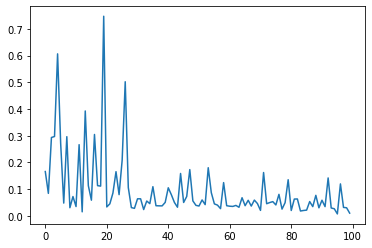

In [18]:
%%time 

torch.autograd.set_detect_anomaly(True)

l2l = L2LRot(circ_function, num_feats=1, batch_size=1)

optimizer = optim.Adam(l2l.parameters(), lr=0.1)

num_epoch = 100
num_steps = 10 #25

all_loss = []
for epoch_ind in tqdm(range(num_epoch)):

    l2l.zero_grad()
    l2l.init_hid_cell()
    l2l.init_target()

    for i in range(num_steps):
#         print(i)
        l2l.step()

    loss = l2l.loss()
    loss.backward()
    optimizer.step()

    all_loss.append(loss.item())

plt.plot(all_loss)